# **IMPORTANDO E ANALISANDO OS DADOS**

In [ ]:
!pip install scikeras

In [2]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("StudentsPerformance.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


**Verificando se há dados nulos:**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [ ]:
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

**Verificando se há dados duplicados:**

In [ ]:
df.duplicated().sum()

0

**Vamos criar uma coluna de média das notas que servirá como target:**

In [5]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [6]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


**Transformando as Features categóricas em numéricas - OrdinalEncoder().**

In [7]:
#'gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score'
oe =  OrdinalEncoder()
oe.fit(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])

df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']] = oe.transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'media'],
      dtype='object')

In [9]:
ssc = StandardScaler()

ssc.fit(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])
h= ssc.transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']])
df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']] = h

# **DATASET BASE**

In [11]:
X = df.drop(columns="media")
y = df["media"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=5, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=5, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [10],
          "kr__epochs":[1000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 504/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.5966 - mean_absolute_error: 10.5966
Epoch 505/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.2291 - mean_absolute_error: 10.2291
Epoch 506/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.0090 - mean_absolute_error: 10.0090
Epoch 507/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.4125 - mean_absolute_error: 10.4125
Epoch 508/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.8211 - mean_absolute_error: 10.8211
Epoch 509/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.3473 - mean_absolute_error: 10.3473
Epoch 510/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.9970 - mean_absolute_error: 10.9970
Epoch 511/1000
72/72 [==============================] - 0s 2ms/step - loss: 10.7321 - mean_absolute_error: 10.7321
Epoch 512/1000
72/72 

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('kr',
                                        KerasRegressor(model=<function criarRede at 0x7f82ecf9f4d0>))]),
             param_grid={'kr__batch_size': [10], 'kr__epochs': [1000],
                         'kr__optimizer': ['adam']},
             scoring='neg_mean_absolute_error', verbose=10)

In [12]:
grid_kr.best_params_

{'kr__batch_size': 10, 'kr__epochs': 1000, 'kr__optimizer': 'adam'}

In [13]:
grid_kr.best_score_

-5.796848073005675

In [14]:
y_pred = grid_kr.predict(X_test)

20/20 [==============================] - 0s 1ms/step


In [15]:
y_pred

array([77.96622 , 59.576126, 68.30675 , 68.10708 , 73.752464, 70.73959 ,
       62.233513, 55.51903 , 70.198685, 51.45768 , 51.45768 , 51.45768 ,
       69.23545 , 54.917786, 75.38075 , 68.4039  , 51.45768 , 51.45768 ,
       51.45768 , 57.297844, 66.99015 , 51.45768 , 58.509155, 51.45768 ,
       71.91201 , 70.18781 , 65.97116 , 51.45768 , 51.45768 , 52.757256,
       56.272263, 61.931755, 56.539062, 66.703415, 70.18892 , 51.45768 ,
       69.13573 , 67.79053 , 68.3284  , 51.45768 , 70.79335 , 59.83354 ,
       60.57566 , 57.359306, 75.57385 , 60.829628, 65.10948 , 51.45768 ,
       77.537   , 71.37093 , 66.01459 , 65.352066, 71.36931 , 51.505043,
       65.654236, 66.17169 , 74.755615, 51.925102, 73.71003 , 79.722305,
       51.45768 , 73.00384 , 71.51998 , 57.616512, 78.631546, 67.32562 ,
       60.294914, 51.950348, 60.068214, 79.32846 , 59.749214, 77.46226 ,
       53.316196, 51.45768 , 56.316196, 69.73118 , 80.20506 , 53.577133,
       56.036846, 51.45768 , 57.331726, 51.45768 , 

In [16]:
tabela = pd.DataFrame()

In [17]:
tabela["Valor real"] = y_test

In [18]:
tabela["Valor preditivo"] = y_pred

In [19]:
tabela = tabela.sort_index()
tabela = tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo
0,10,54.666667,51.925102
1,23,71.666667,65.654236
2,25,73.000000,66.785103
3,30,72.333333,66.171692
4,39,56.666667,53.577133
...,...,...,...
195,985,54.000000,51.525402
196,986,50.000000,51.457680
197,989,78.666667,71.377129
198,995,94.000000,83.416626


In [20]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 90.53%


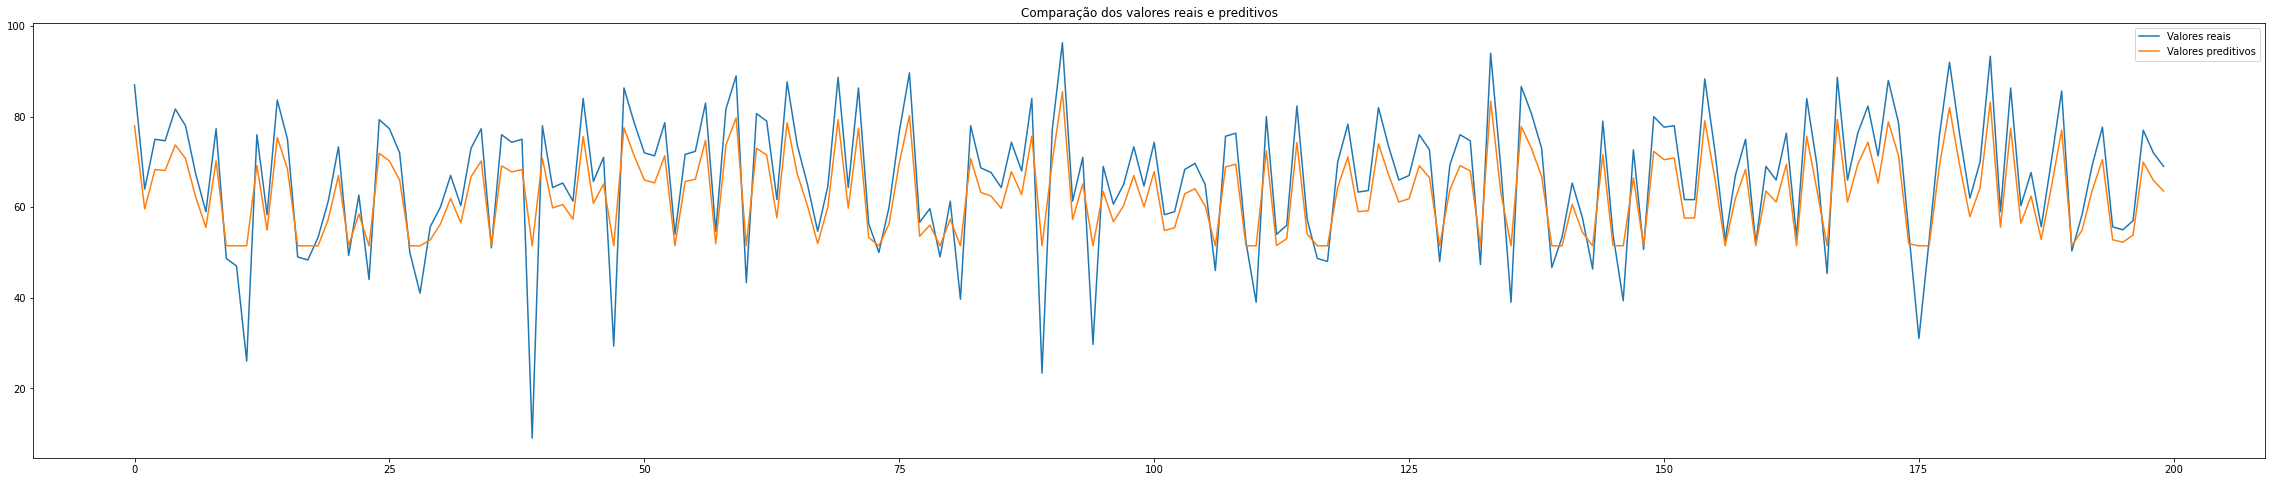

In [21]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();

In [22]:
import pickle

In [23]:
with open("grid_kr.pkl", "wb") as f:
    pickle.dump(grid_kr, f)

In [ ]:
with open("grid_kr.pkl", "rb") as f:
    
    grid_kr = pickle.load(f)